# Onion or Not

The inspiration for this project was [Luke Feilberg](https://github.com/lukefeilberg/onion) data of reddit titles (headlines) from two subreddits: [r/TheOnion](https://www.reddit.com/r/TheOnion/) and [r/NotTheOnion](https://www.reddit.com/r/nottheonion/).
r/TheOnion is a collection of the most popular articles from [The Onion](https://www.theonion.com/), a satirical news 
website. Submissions to r/NotTheOnion are instead articles from various news sources that, while legitimate, "are so mind-blowingly ridiculous that you could have sworn they were from The Onion". This presents an interesting
classification problem: can an algorithm tell the difference between satirical headlines and headlines that reddit users 
think <i>could</i> be satirical.  

The [original dataset](https://github.com/lukefeilberg/onion/blob/master/OnionOrNot.csv) contained 24,000 records, but using the method Luke built for pulling data, I gathered an additional 
6,000 records to make the dataset balanced with 15,000 r/TheOnion headlines and 15,000 r/NotTheOnion headlines.

Onion articles are often reposted on social media and misidentified by users as legitimate headlines, leading to confusion. Those confused users are said to have "ate the onion", so perhaps this model could be used help them spit it back out :)

Some examples of Onion headlines:  
[27-Year-Old Lies About Every Single Aspect Of His Life To Keep Parents From Worrying](https://local.theonion.com/27-year-old-lies-about-every-single-aspect-of-his-life-1819575793)  
[More People Should Have Donated: Wikipedia Has Announced They Will Be Forced To Take Down Their Entry For ‘Ostrich’ Due To Lack Of Funding](https://news.clickhole.com/more-people-should-have-donated-wikipedia-has-announce-1838637936)  
[CIA Realizes It's Been Using Black Highlighters All These Years](https://politics.theonion.com/cia-realizes-its-been-using-black-highlighters-all-thes-1819568147)  

Some examples of Not The Onion headlines:  
[UPS Loses Family's \\$846K Inheritance, Offers to Refund \\$32 Shipping Fee](https://www.abc.net.au/triplej/programs/hack/2020-edelman-trust-barometer-shows-growing-sense-of-inequality/11883788?fbclid=IwAR09iusXpbCQ6BM5Fmsk4MVBN3OWIk2L5E8UbQKFwjg6nWpLHKgMGP2UTfM)  
[Distilleries using high-proof alcohol to make hand sanitizer](https://abcnews.go.com/Business/wireStory/distilleries-high-proof-alcohol-make-hand-sanitizer-69632364)  
[People no longer believe working hard will lead to a better life, survey shows](https://www.abc.net.au/triplej/programs/hack/2020-edelman-trust-barometer-shows-growing-sense-of-inequality/11883788?fbclid=IwAR09iusXpbCQ6BM5Fmsk4MVBN3OWIk2L5E8UbQKFwjg6nWpLHKgMGP2UTfM)

In [1]:
# Imports
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import torch
import transformers as hft
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', 250)
tqdm.pandas()

Using TensorFlow backend.


## Load in the saved data

In [2]:
data = pd.read_csv('OnionOrNot_large.csv')

print(f'Number of r/TheOnion headlines: {len(data[data["label"] == 1])}')
print(f'Number of r/NotTheOnion headlines: {len(data[data["label"] == 0])}')

Number of r/TheOnion headlines: 15000
Number of r/NotTheOnion headlines: 15000


## Some light Data Cleaning

In [3]:
# remove all headlines with length less than 15, as most below that limit seem to be nonsense/errors
data = data[data['text'].str.len() >= 15]

# several headlines are accidentally links, so remove headlines that start with 'https://'
data = data[~data['text'].str.startswith('https://')]
data = data.reset_index(drop=True)

batches = np.array_split(data, 30) # split into parts so we can batch load them through DistilBERT

print(f'Number of r/TheOnion headlines after cleaning: {len(data[data["label"] == 1])}')
print(f'Number of r/NotTheOnion headlines after cleaning: {len(data[data["label"] == 0])}')

Number of r/TheOnion headlines after cleaning: 14889
Number of r/NotTheOnion headlines after cleaning: 14984


## Feature engineering

Number of words in headline

In [4]:
data['num_words'] = data['text'].apply(lambda x: len(x.split(' ')))
print(f'Average number of words in r/TheOnion: {data[data["label"] == 1]["num_words"].mean():.2f}')
print(f'Average number of words in r/NotTheOnion: {data[data["label"] == 0]["num_words"].mean():.2f}')

Average number of words in r/TheOnion: 13.52
Average number of words in r/NotTheOnion: 11.12


Whether the headline contains the word 'onion'. Many of The Onion's headlines are something like: "Welcome To Onion Social, The Onion's New Social Media Platform", so this could be predictive.

In [8]:
data['contains_onion'] = data['text'].apply(lambda x: 1 if 'onion' in x.lower() else 0)
print(f'Number of r/TheOnion articles with "onion" in title: {data[(data["contains_onion"] == 1) & (data["label"] == 1)]["contains_onion"].count()}')
print(f'Number of r/NotTheOnion articles with "onion" in title: {data[(data["contains_onion"] == 1) & (data["label"] == 0)]["contains_onion"].count()}')

Number of r/TheOnion articles with "onion" in title: 501
Number of r/NotTheOnion articles with "onion" in title: 54


Calculates the grade level needed to read the title with [textstat](https://pypi.org/project/textstat/), which combines many metrics into one. Most of those metrics use things like number of syllables, characters per word, number of predefined "easy" words, etc.

Average readability in r/TheOnion: 8.32
Average readability in r/NotTheOnion: 7.73


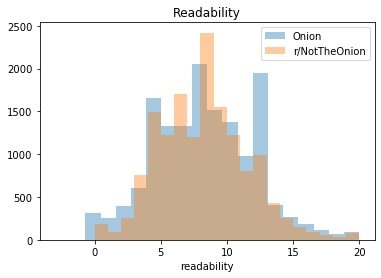

In [6]:
# readability of headline (cap of 20, as it's supposed to correspond to grade level)
data['readability'] = data['text'].apply(lambda x: 20 if textstat.text_standard(x, float_output=True) > 20 else textstat.text_standard(x, float_output=True))
# data['readability'] = data['text']
print(f'Average readability in r/TheOnion: {data[data["label"] == 1]["readability"].mean():.2f}')
print(f'Average readability in r/NotTheOnion: {data[data["label"] == 0]["readability"].mean():.2f}')

onion_data = data[data['label'] == 1]
not_the_onion_data = data[data['label'] == 0]

# plot distribution of readability
sns.distplot(onion_data['readability'], bins=20, kde=False, label='Onion')
sns.distplot(not_the_onion_data['readability'], bins=20, kde=False, label='r/NotTheOnion')
plt.title('Readability')
plt.legend()

Percent of words that are uppercase

Average percent of words that are capitalized in r/TheOnion articles: 92.80%
Average percent of words that are capitalized in r/NotTheOnion articles: 37.15%


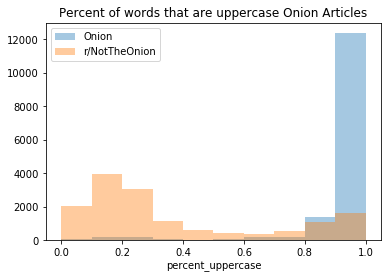

In [7]:
def percent_uppercase(x):
    num_words = x['num_words']
    num_upper = 0
    for word in x['text'].split(' '):
        if len(word) > 0 and word[0].isupper() :
            num_upper += 1

    return num_upper / num_words
        
data['percent_uppercase'] = data.apply(percent_uppercase, axis=1)

print(f'Average percent of words that are capitalized in r/TheOnion articles: {100 * data[data["label"] == 1]["percent_uppercase"].mean():.2f}%')
print(f'Average percent of words that are capitalized in r/NotTheOnion articles: {100 * data[data["label"] == 0]["percent_uppercase"].mean():.2f}%')


onion_data = data[data['label'] == 1]
not_the_onion_data = data[data['label'] == 0]

# plot distribution of percent uppercase
sns.distplot(onion_data['percent_uppercase'], bins=10, kde=False, label='Onion')
sns.distplot(not_the_onion_data['percent_uppercase'], bins=10, kde=False, label='r/NotTheOnion')
plt.title('Percent of words that are uppercase Onion Articles')
plt.legend()

### percent_uppercase: too good of a predictor
It would turn out that `percent_uppercase` is a pretty predictive feature. Most r/TheOnion headlines capitalize almost every word, 
while r/NotTheOnion is more inconsistent.  

I want to take a step back though and think about why that might be. Remember that these headlines are actually the 
<i>titles</i> of Reddit posts. r/NotTheOnion specifies that title of the post must be <b>exactly</b> the same as the 
news article's headline. r/TheOnion does not have any similar rules posted in their subreddit. Thus, this pattern could 
be affected by each subreddit's users or moderator behavior.  

I would also like our model closer to a general satire classifier than a "r/NotTheOnion vs r/TheOnion" classifier, so I 
remove `percent_uppercase` from our list of features as it will probably cause our model to be overfit to this 
particular dataset.

In [9]:
data = data.drop('percent_uppercase', axis=1)

# First Model
I manually tried to classify 100 headlines and ended up with 81 correct. While not super scientific, I think that 
represents a decent benchmark for how we'd want a model to perform.  

Let's see how some easy-to-make models like logistic regression and a random forest classifier fair using the features 
we created.

In [10]:
# split up data
labels = data['label']
features = data[['num_words', 'contains_onion', 'readability']]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25)

# logistic regression
first_lr_model = LogisticRegression()
first_lr_model.fit(train_features, train_labels)
print(f'LogisticRegression Train Accuracy: {first_lr_model.score(test_features, test_labels)}')

# random forest
first_rf_model = RandomForestClassifier()
first_rf_model.fit(train_features, train_labels)
print(f'RandomForestClassifier Train Accuracy: {first_rf_model.score(test_features, test_labels)}')


LogisticRegression Train Accuracy: 0.6208327754719507
RandomForestClassifier Train Accuracy: 0.6579194001874414


While these features and models are better than random chance, 62-65% accuracy is not very close to my "human level" accuracy of 81%. Luckily, there have been some great advancements in NLP in recent years that do a better job of taking into account the meanings of words in our headlines.

# DistilBERT

[BERT](https://github.com/google-research/bert) was a new NLP model released by Google in late 2018. It was a huge leap 
in the way we treat NLP, bringing together new ideas like attention and transformers in a way that helped get it some 
of the highest accuracy scores on many metrics.

For our purpose of classifying Onion articles, we'll use Hugging Face's [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html), 
a version of BERT that preserves over 95% of BERT's accuracy while still being able to comfortably run on a laptop. 
From their package, we'll use two functions:


 - `db_tokenizer` is what will turn our text into a list of 'tokens' (eg."I didn't go to the supermarket" turns into \["I", "didn't", "go", "to", "the", "supermarket"\]).
   - Note that it will continue to split the sentence up until it only contains tokens that are in the DistilBERT 
   dataset. For words it doesn't know, like the word "counterpoint", this is alright as it gets split into "counter" and "point". That looks reasonable. There are many words  this does not work for. "Hulu", for example, gets split into "hu" and "lu".

 - `db_model` is the DistilBERT model that we feed our tokens into to get our sentence representations

In [11]:
db_tokenizer = hft.DistilBertTokenizer
db_model = hft.DistilBertModel

# Load pretrained model/tokenizer
db_tokenizer = db_tokenizer.from_pretrained('distilbert-base-uncased')
db_model = db_model.from_pretrained('distilbert-base-uncased')

## Tokenize and encode the titles
To feed our titles into DistilBERT, they first need to be [tokenized](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html). The tokenizer also adds a "[CLS]" token at the beginning and a "[SEP]" token at the end, which the model would use to know how to separate sentences if our text contained multiple sentences.

Of course, the DistilBERT model has to take in numbers as input, so we actually use `db_tokenizer.encode_plus()`, 
which gives us the index of each token instead of the actual text string. It also provides the attention mask, 
which we'll use later.


In [12]:
tokenized_batches = []
for batch in tqdm(batches):
    # get the length of the longest tokenized headline in this batch so we can pass that length to db_tokenizer.encode_plus()
    batch['tokenized'] = batch['text'].apply(lambda x: db_tokenizer.tokenize(x, add_special_tokens=True))
    max_tokens = batch['tokenized'].apply(len).max()
    
    # store dictionary results of db_tokenizer.encode_plus() in a column, then split tokenized and attention_mask into their own columns
    batch['sequence_dict'] = batch['tokenized'].apply(lambda x: db_tokenizer.encode_plus(x, add_special_tokens=True, max_length=max_tokens, pad_to_max_length=True))
    batch['tokenized'] = batch['sequence_dict'].apply(lambda x: x['input_ids'])
    batch['attention_mask'] = batch['sequence_dict'].apply(lambda x: x['attention_mask'])
    tokenized_batches.append(batch.drop('sequence_dict', axis='columns'))

# show an example encoded title
print(f'Max tokenized length for first batch: {len(tokenized_batches[0].loc[0, "tokenized"])}')
print(f'Ex. Tokenized/encoded version: {tokenized_batches[0].loc[0, "tokenized"]}')
print(f'Ex. Original sentence: {db_tokenizer.decode(tokenized_batches[0].loc[0, "tokenized"])}')

100%|██████████| 30/30 [00:08<00:00,  3.51it/s]

Max tokenized length for first batch: 44
Ex. Tokenized/encoded version: [101, 2053, 2062, 3097, 7570, 2229, 1010, 8183, 24144, 2072, 2758, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ex. Original sentence: [CLS] no more foreign hoes, jokowi says [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## Store tokenized batches as numpy arrays

In [13]:
input_ids_batches = []
for batch in tokenized_batches:
    input_ids_batches.append(np.array(batch['tokenized'].tolist()))

## Create Attention mask
Our model shouldn't consider the "[PAD]" tokens when computing attention. When we run our model, we'll use the 
attention masks provided by `db_tokenizer.encode_plus()` to let the model know to ignore them. See details 
[here](https://huggingface.co/transformers/glossary.html#attention-mask)

In [14]:
attention_masks = []
for batch in tokenized_batches:
    attention_masks.append(np.array(batch['attention_mask'].tolist()))

## Now for the fun part!
This part puts each of our batches into the DistilBERT model, which will turn our array of headlines into arrays of 
768-d sentence embeddings. If these sentence embeddings contain useful information (which they have been shown to), 
then a downstream model should find them useful and should do a better job of classifying whether a headline is from r/TheOnion or r/NotTheOnion. (Note: this step takes about 10 minutes on my laptop)

In [15]:
last_hidden_states = []

for i in tqdm(range(len(input_ids_batches))):
    # convert tokenized headlines(which you'll recall are actually the indexes of the tokens) array into a PyTorch tensor
    input_ids = torch.tensor(input_ids_batches[i]).to(torch.int64)
    # concert attention_mask array into a PyTorch tensor
    attention_mask = torch.tensor(attention_masks[i])
 
    # feed these tensors into the DistilBERT model
    with torch.no_grad():
        last_hidden_states.append(db_model(input_ids, attention_mask=attention_mask))

    i += 1

100%|██████████| 30/30 [11:57<00:00, 23.90s/it]


By default, the model returns all of the weights for each encoding layer. We only want the last layer's weights to use as our word embeddings, however, so we select the last layer's weights and convert it to numpy with `last_hidden_state[0][:,0,:].numpy()`.

In [ ]:
last_layer_features = []
for last_hidden_state in last_hidden_states:
    last_layer_features.append(last_hidden_state[0][:,0,:].numpy())

unbatched_data = pd.DataFrame(np.concatenate(last_layer_features))

The final step before building a model is to split into training and test sets

In [ ]:
db_data = data.join(unbatched_data)
labels = db_data['label']
features = db_data.drop('label', axis='columns')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25)

# take out text as it's not a model feature, but save them so we can see which ones the model got right or wrong
train_text, test_text = train_features.pop('text'), test_features.pop('text')

## DistilBERT Results
Using only an out-of-the-box Logistic Regression model, accuracy is <i>significantly</i> better, jumping up >20 percentage points to about 86%.

In [ ]:
db_lr_clf = LogisticRegression(max_iter=300)
db_lr_clf.fit(train_features, train_labels)

print('lr train', db_lr_clf.score(train_features, train_labels))
print('lr test', db_lr_clf.score(test_features, test_labels))

If we plot a confusion matrix, we can see that the model has about the same accuracy for each class

In [ ]:
def plot_confusion_matrix(y_pred, y_actual, title):
    cm = confusion_matrix(list(y_actual), list(y_pred))
    sns.heatmap(cm, linewidths=.5, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
probabilities = pd.DataFrame(db_lr_clf.predict_proba(test_features), columns=['prob_not_onion', 'prob_onion'])
probabilities['prediction'] = probabilities['prob_not_onion'].apply(lambda x: 1 if x < 0.5 else 0)
predictions = pd.concat([test_text.reset_index(drop=True), probabilities, test_labels.reset_index(drop=True), test_features.reset_index(drop=True)], axis=1)
plot_confusion_matrix(predictions['prediction'], test_labels, 'lr_clf')

### Where did things go wrong?

In [ ]:
pred_onion = predictions[predictions['prediction'] == 1].copy()
pred_not_onion = predictions[predictions['prediction'] == 0].copy()

pred_onion.sort_values(by='prob_not_onion', ascending=False)[['text', 'prob_not_onion', 'label']].head(5)

# Appendix

## Neural Network
Neural networks are often good at finding patterns when there are many input variables. Here, however, it seems like it doesn't perform much better than Logistic Regression. With some hyperparameter tuning that could change, but I often favor simplicity over small gains in accuracy.

In [ ]:
model = Sequential()
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001), input_dim=768))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_features, train_labels, epochs=50, batch_size=16,
          validation_data=(test_features, test_labels), callbacks=[EarlyStopping(patience=3, monitor='val_loss')])

In [ ]:
def predict_onion(headline: str, model):
    headline = headline.lower()
    tokenized = db_tokenizer.tokenize(headline, add_special_tokens=True)
    encoded = np.array([db_tokenizer.encode(tokenized)])
    input_ids = torch.tensor(encoded).to(torch.int64)

    with torch.no_grad():
        last_hidden_state = db_model(input_ids)
#         for i in last_hidden_state[0]:
#             print(i)
        embedding = last_hidden_state[0][:,0,:].numpy()
        df = pd.DataFrame(embedding)
#         return df
        prediction = model.predict_proba(df)[0][0]
        if prediction < .5:
            print(f'The classifier is {100*(1-prediction):.1f}% sure this is The Onion')
        else:
            print(f'The classifier is {100*prediction:.1f}% sure this is Not The Onion')
    
predict_onion('High Court to doctors: Write legible prescriptions')